<a href="https://colab.research.google.com/github/NickVoulg02/Information-Retrieval/blob/main/colbert_test_link.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ColBERTv2: Indexing & Search Notebook
First, we'll import the relevant classes. Note that `Indexer` and `Searcher` are the key actors here. Next, we'll download the necessary dependencies.

In [16]:
!git -C ColBERT/ pull || git clone https://github.com/stanford-futuredata/ColBERT.git
import sys; sys.path.insert(0, 'ColBERT/')


Already up to date.


In [2]:
try: # When on google Colab, let's install all dependencies with pip.
    import google.colab
    !pip install -U pip
    !pip install -e ColBERT/['faiss-gpu','torch']
except Exception:
  import sys; sys.path.insert(0, 'ColBERT/')
  try:
    from colbert import Indexer, Searcher
  except Exception:
    print("If you're running outside Colab, please make sure you install ColBERT in conda following the instructions in our README. You can also install (as above) with pip but it may install slower or less stable faiss or torch dependencies. Conda is recommended.")
    assert False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
Obtaining file:///content/ColBERT
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 55.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 25.6 

In [3]:
import colbert

In [4]:
from colbert import Indexer, Searcher
from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert.data import Queries, Collection

We will use the docs files and the Queries_20 file.

In [5]:
#importing tsv files from personal github repository and creating docs dataset and queries
!git clone https://github.com/NickVoulg02/Information-Retrieval.git
import pandas as pd
from datasets import Dataset
dataset = 'test'
df1 = pd.read_csv("Information-Retrieval/colbert_test/doc_col.tsv", delimiter = '\t', index_col=0)
collection = Dataset.from_pandas(df1, preserve_index=True)
query = Queries("Information-Retrieval/colbert_test/queries_20.tsv")
f'Loaded {len(query)} queries and {len(collection):,} passages'

Cloning into 'Information-Retrieval'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 111 (delta 36), reused 15 (delta 15), pack-reused 59
Receiving objects: 100% (111/111), 607.24 KiB | 12.39 MiB/s, done.
Resolving deltas: 100% (45/45), done.
[Jan 29, 22:31:17] #> Loading the queries from Information-Retrieval/colbert_test/queries_20.tsv ...
[Jan 29, 22:31:17] #> Got 20 queries. All QIDs are unique.



'Loaded 20 queries and 1,209 passages'

In [6]:
print(query[0])
print(collection[0])

WHAT ARE THE EFFECTS OF CALCIUM ON THE PHYSICAL PROPERTIES OF MUCUS FROM CF PATIENTS
{'doc': 'PSEUDOMONAS AERUGINOSA INFECTION IN CYSTIC FIBROSIS OCCURRENCE OF PRECIPITATING ANTIBODIES AGAINST PSEUDOMONAS AERUGINOSA IN RELATION TO THE CONCENTRATION OF SIXTEEN SERUM PROTEINS AND THE CLINICAL AND RADIOGRAPHICAL STATUS OF THE LUNGS THE SIGNIFICANCE OF PSEUDOMONAS AERUGINOSA INFECTION IN THE RESPIRATORY TRACT OF 9 CYSTIC FIBROSIS PATIENTS HAVE BEEN STUDIED BY MEANS OF IMMUNOELECTROPHORETICAL ANALYSIS OF PATIENTS SERA FOR THE NUMBER OF PRECIPITINS AGAINST PSEUDOMONAS AERUGINOSA AND THE CONCENTRATIONS OF 16 SERUM PROTEINS IN ADDITION THE CLINICAL AND RADIOGRAPHICAL STATUS OF THE LUNGS HAVE BEEN EVALUATED USING 2 SCORING SYSTEMS PRECIPITINS AGAINST PSEUDOMONAS AERUGINOSA WERE DEMONSTRATED IN ALL SERA THE MAXIMUM NUMBER IN ONE SERUM WAS 22 THE CONCENTRATIONS OF 12 OF THE SERUM PROTEINS WERE SIGNIFICANTLY CHANGED COMPARED WITH MATCHED CONTROL PERSONS NOTABLY IGG AND IGA WERE ELEVATED AND THE AC

## Indexing

For an efficient search, we can pre-compute the ColBERT representation of each passage and index them.

Below, the `Indexer` take a model checkpoint and writes a (compressed) index to disk. We then prepare a `Searcher` for retrieval from this index.

In [7]:
nbits = 2   # encode each dimension with 2 bits
doc_maxlen = 300 # truncate passages at 300 tokens

index_name = f'{dataset}.{nbits}bits'

Now run the `Indexer` on the collection subset. Assuming the use of only one GPU, this cell should take about six minutes to finish running.

In [8]:
checkpoint = 'colbert-ir/colbertv2.0'

with Run().context(RunConfig(nranks=1, experiment='notebook')):                   # nranks specifies the number of GPUs to use
    config = ColBERTConfig(doc_maxlen=doc_maxlen, nbits=nbits, kmeans_niters=4)   # kmeans_niters specifies the number of iterations of k-means clustering; 4 is a good and fast default.
                                                                                  # Consider larger numbers for small datasets.

    indexer = Indexer(checkpoint=checkpoint, config=config)
    indexer.index(name=index_name, collection=collection["doc"], overwrite=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


artifact.metadata:   0%|          | 0.00/1.63k [00:00<?, ?B/s]



[Jan 29, 22:31:29] #> Creating directory /content/experiments/notebook/indexes/test.2bits 


#> Starting...
#> Joined...


In [9]:
indexer.get_index() # You can get the absolute path of the index, if needed.

'/content/experiments/notebook/indexes/test.2bits'

## Search

Having built the index and prepared our `searcher`, we can search for individual query strings.

In [10]:
# To create the searcher using its relative name (i.e., not a full path), set
# experiment=value_used_for_indexing in the RunConfig.
with Run().context(RunConfig(experiment='notebook')):
    searcher = Searcher(index=index_name, collection=collection["doc"])

[Jan 29, 22:36:27] #> Loading codec...
[Jan 29, 22:36:27] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Jan 29, 22:36:27] Loading packbits_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Jan 29, 22:36:27] #> Loading IVF...
[Jan 29, 22:36:27] #> Loading doclens...


100%|██████████| 1/1 [00:00<00:00, 3600.26it/s]

[Jan 29, 22:36:27] #> Loading codes and residuals...



100%|██████████| 1/1 [00:00<00:00, 152.34it/s]


In [11]:
question = query[14]

# Find the top-10 passages for this query
results = searcher.search(question, k=30)
#print(results)

passages_ranked = {}
#Print out the top-k retrieved passages
print("Rank\tScore\tId\tPassage")
for passage_id, passage_rank, passage_score in zip(*results):
     print(f"[{passage_rank}] \t{passage_score:.1f} \t{collection['doc_id'][passage_id]} \t{searcher.collection[passage_id]}")
     passages_ranked[passage_id] = passage_rank


#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . WHAT ARE THE HEPATIC COMPLICATIONS OR MANIFESTATIONS OF CF, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2024,  1996,  2002, 24952,  2278, 12763,  2030,
        24491,  2015,  1997, 12935,   102,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

Rank	Score	Id	Passage
[1] 	21.3 	301 	GASTROINTESTINAL MANIFESTATIONS OF CYSTIC FIBROSIS FROM A HISTORICAL VIEW CYSTIC FIBROSIS CF HAS BEEN CONSIDERED A DISEASE OF THE PANCREAS WHICH RESULTS IN MALDIGESTION AND LOSS OF FAT AND NITROGEN IN THE STOOL A NUMBER OF EARLY SYNONYMS INCLUDED CONGENITAL STEATORRHEA PANCREATIC INFANTILISM AND PANCREATIC FIBROSIS THE CONCE

Metrics


In [12]:
f = open("Information-Retrieval/Relevant_20", "r")
file = f.read().splitlines()
relevant_docs = []
for line in file:
    line=line.split()
    list = []
    for num in line:
        num = int(num)
        list.append('doc'+str(num))
    relevant_docs.append(list)                  # relevant_docs list includes every line from Relevant_20

Mean Average Precision

0.25025136218216215
0.1275958667167708
0.19042972362417085
0.2904289240181963
0.19663148346453152
0.18654405298509594
0.09508615757294149
0.057845607349380226
0.2558358131230472
0.30091203317584414
0.6061873311125703
0.16263126778194076
0.12594239063843188
0.21404384548037259
0.15943431927260845
0.22319432312345341
0.1053961082824507
0.14575299700765537
0.07857902536760272
0.5313826644821248
Mean Average Precision: 0.21520526483806762


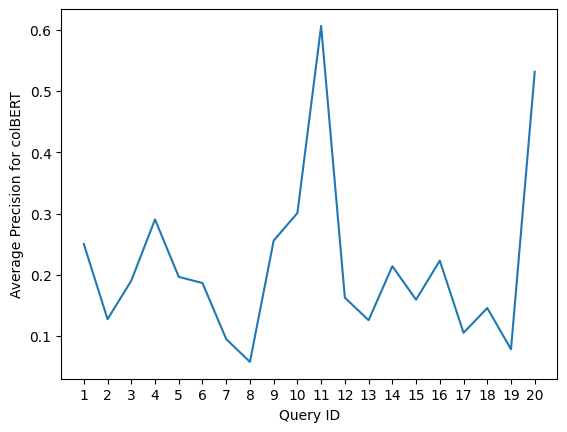

In [17]:
import matplotlib.pyplot as plt
import numpy

avg_pr_list = []
#i=0;
for i in range(20):
    results = searcher.search(query[i], k=400)
    passages_ranked = {}
    for passage_id, passage_rank, passage_score in zip(*results):
      passages_ranked[passage_id] = passage_rank
    precision_at_k = []
    recall_at_k = []
    true_positives = 0

    for key, value in passages_ranked.items():
      doc = "doc"+str(collection['doc_id'][key])
      if(doc in relevant_docs[i]):
        #print(doc)
        true_positives+=1
        #print(value)
        precision_at_k.append(true_positives/value)

    average_precision = 0
    for x in range(len(precision_at_k)):
      average_precision += precision_at_k[x]

    #print(average_precision)
    average_precision = average_precision/len(relevant_docs[i])
    print(average_precision)
    avg_pr_list.append(average_precision)

mean_average_precision = sum(avg_pr_list)/20
print("Mean Average Precision: " + str(mean_average_precision))

plt.xticks(numpy.arange(len(avg_pr_list)), numpy.arange(1, len(avg_pr_list)+1))
ypoints = numpy.array(avg_pr_list)
plt.xlabel("Query ID")
plt.ylabel("Average Precision for colBERT")
plt.plot(ypoints)
plt.show()

Mean Reciprocal Rank

In [20]:
mean_rep_rank = 0
for i in range(20):
    results = searcher.search(query[i], k=400)
    passages_ranked = {}
    for passage_id, passage_rank, passage_score in zip(*results):
      passages_ranked[passage_id] = passage_rank

    for key, value in passages_ranked.items():
      doc = "doc"+str(collection['doc_id'][key])
      if(doc in relevant_docs[i]):
            mean_rep_rank += 1/value
            break

mean_rep_rank = mean_rep_rank/20
print("Mean Reciprocal Rank:"+str(mean_rep_rank))


Mean Reciprocal Rank:0.7333333333333333
